# Proof of Principal Opinion Poll
Here we use search terms 'bio manufacturing' to query twitter for tweets, frequency of tweets, hashtags, mentions to discover who is talking and how they are talking about this topic

## Import packages

In [394]:
##IMPORT PACKAGES##
# For sending GET requests from the API
import requests
# For saving access tokens and for file management when creating and adding to the dataset
# For dealing with json responses we receive from the API
import json
#for locally saved data
import os
# For displaying the data after
import pandas as pd
# For saving the response data in CSV format
import csv
# For parsing the dates received from twitter in readable formats
# For Creating a timeseries with which to query twitter
import pytz
import datetime
import dateutil.parser
import unicodedata
from datetime import datetime,  timedelta
import matplotlib.pyplot as plt
import re
#prepare the data for tpoic analysis
from nltk.corpus import stopwords 
import string
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
#summarization
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.lex_rank import LexRankSummarizer
from sumy.summarizers.luhn import LuhnSummarizer
from sumy.summarizers.lsa import LsaSummarizer
from sumy.nlp.stemmers import Stemmer
from sumy.utils import get_stop_words
from sumy.summarizers.text_rank import TextRankSummarizer
import numpy as np


## Load saved query


In [404]:
def load_saved_data(keyword):
    path = f'/Users/maryward/twitter_project/data_tsung/biomanufacturing/'
    #path = f'{path}{keyword}.csv'
    count = 0
    for file in os.listdir(path):
        print(file)
        # open the file
        with open(os.path.join(path, file), 'rb') as f:
            print(f)
            df = pd.read_csv(f)
            df['date'] = file[:10]
            if count ==0:
                df2 = df
                count +=1
            else:
                print(count)
                df2 = pd.concat([df,df2], axis = 0)
    return df2

In [405]:
keyword = 'biomanufacturing'
mark_priv_df = load_saved_data(keyword)

privacy marketing.csv
<_io.BufferedReader name='/Users/maryward/twitter_project/data_Quick/privacy marketing.csv'>


In [407]:
len(mark_priv_df)
data_frame = mark_priv_df

## Twitter API call

In [732]:
def create_headers():
    bearer_token = 'AAAAAAAAAAAAAAAAAAAAALyLcAEAAAAA9MBGXsNUoEcuPoIOeMWFs3kMuSg%3DU3tz61tblOdVbgLXekmuvvPYnCWZA35S6i66YrNhS5DyaXaCgS'
    '''create headers from bearer token'''
    headers = {"Authorization": "Bearer {}".format(bearer_token)}
    return headers

def create_url(keyword, start_date, end_date, max_results = 100):
    '''make a url for the API call'''
    search_url = "https://api.twitter.com/2/tweets/search/recent" #Change to the endpoint you want to collect data from
    query_params = {'query': keyword,
                    'start_time': start_date,
                    'end_time': end_date, #start-time limited to 1 week with Essential Access from Twitter
                    'max_results': max_results, #maximum is 100
                    'expansions': 'author_id,in_reply_to_user_id,geo.place_id',
                    'tweet.fields': 'id,text,author_id,in_reply_to_user_id,geo,conversation_id,created_at,lang,public_metrics,referenced_tweets,reply_settings,source,context_annotations',
                    'user.fields': 'id,name,username,created_at,description,public_metrics,verified',
                    'place.fields': 'full_name,id,country,country_code,geo,name,place_type',
                    'next_token': {}}
    return (search_url, query_params)

def connect_to_endpoint(url, headers, params, next_token = None):
    '''function to connect to twitter API endpoint'''
    params['next_token'] = next_token   #params object received from create_url function
    response = requests.request("GET", url, headers = headers, params = params)
    print("Endpoint Response Code: " + str(response.status_code))
    if response.status_code != 200:
        raise Exception(response.status_code, response.text)
    return response.json()

def loop_through_query(headers, keyword , start_time , end_time ,n_tweets = 1000, max_results = 100):
    """funtion loops through next_tokens to return n_tweets"""
    '''define '''
    # now we have two json STRINGS
    next_token = None
    url = create_url(keyword, start_time,end_time, max_results)
    json_response = connect_to_endpoint(url[0], headers, url[1], next_token)
    if json_response['meta']['result_count']>0:
        df_keep = pd.DataFrame(json_response['data'])    
        for i in range(round(n_tweets/100)):
            if next_token:
                url = create_url(keyword, start_time,end_time, max_results)
                json_response = connect_to_endpoint(url[0], headers, url[1], next_token)
                keys = list(json_response.keys())
                #if len(json_response) !=0:
                if json_response['meta']['result_count']>0:
                    df_new = pd.DataFrame(json_response['data'])
                   # df_new = df[['created_at','source', 'text', 'author_id',  'conversation_id','context_annotations']] #'geo',
                    df_keep = pd.concat([df_keep, df_new], axis=0) #final_dict = {key: value for (key, value) in (final_dict.items() + dictA.items())}
            if json_response['meta']['result_count'] >= max_results:
                next_token = json_response['meta']['next_token']
            else:
                next_token = None
        return df_keep
    else:
        return print("No Results")


In [672]:
#time series cut by for a week
def recent_time_by_hour(hours):
    '''creates a list of dates to cycle through for making a times series for hours
    up to one week back max = 168'''
    start_times = []
    end_times = []
    for i in range(hours):
        today = datetime.today() - timedelta(hours=5.05) #timedelta based on diff to UTC, 2.05 from Amsterdam
        end_date = (today - timedelta(hours=i)).isoformat() #slice by days, could be hours, minutes, etc.
        start_date = (today - timedelta(hours=(i+1.05))).isoformat()
        start_times.append((start_date[:23]+'Z'))
        end_times.append((end_date[:23]+'Z'))

    return start_times, end_times

In [674]:
def recent_time_by_hour(hours):
    '''creates a list of dates to cycle through for making a times series for hours
    up to one week back max = 168'''
    start_times = []
    end_times = []
    for i in range(hours):
        today = datetime.today() - timedelta(hours=5.05) #timedelta based on diff to UTC, 2.05 from Amsterdam
        end_date = (today - timedelta(hours=i)).isoformat() #slice by days, could be hours, minutes, etc.
        start_date = (today - timedelta(hours=(i+1.05))).isoformat()
        start_times.append((start_date[:23]+'Z'))
        end_times.append((end_date[:23]+'Z'))

    return start_times, end_times

In [655]:
def time_series_api_call(headers,keyword, n_tweets= 1000, hours=None,  days = None):
    '''takes a list of start and end times and returns a concatenated
    DataFrame of the tweets over the specified times'''
    count = 0
    if hours:
        start_times, end_times = recent_time_by_hour(hours)
    if days:
        start_times, end_times = recent_time_series(days)
    keyword = f'{keyword} lang:en'
    for start_time, end_time in zip (start_times,end_times):
        df = loop_through_query(n_tweets = n_tweets, headers = headers, keyword = keyword, start_time = start_time, end_time = end_time, max_results = 100)
        if count ==0:
            df2 = df
            count +=1
        # df2 = df2[['created_at','source', 'text', 'author_id',  'conversation_id']]
        else:
            print(count)
            df2 = pd.concat([df,df2], axis = 0)
    return df2

In [649]:
def save_tweets_csv(df,keyword):
    path = f'/Users/maryward/twitter_project/data_tsung/'#change filename
    df.to_csv(f'{path}{keyword}/{keyword}.csv')

In [789]:
#'biomanufactured materials' number of results = 0 20.07.2022
#'Biofabricate'  number of results = 0
# 'Biotextiles' number of results = 0
#try "synbio", "biomaterials"
headers = create_headers()
keyword = 'algal oil'
data_frame = time_series_api_call(headers,keyword, n_tweets= 1000, hours=None,  days = 6)


Endpoint Response Code: 200
Endpoint Response Code: 200
1
Endpoint Response Code: 200
1
Endpoint Response Code: 200
No Results
1
Endpoint Response Code: 200
1
Endpoint Response Code: 200
No Results
1


In [790]:
len(data_frame)

69

In [685]:
#save_tweets_csv(data_frame,'biomanufacturing')

In [677]:
headers = create_headers()
keyword = 'biomanufactured materials'
start_times, end_times = recent_time_series(2)
start_date = start_times[0]
end_date = end_times[0]
url, params = create_url(keyword, start_date, end_date, max_results = 100)
response = connect_to_endpoint(url, headers, params, next_token = None)

Endpoint Response Code: 200


In [679]:
response['meta']['result_count']

0

In [780]:
#total tweets in a week
len(data_frame) #211

1893

In [766]:
#save_tweets_csv(data_frame, 'biomanufacturing')

## When are people tweeting about...

In [767]:
def time_of_tweet(df2, keyword = None): #keyword
    '''returns a histogram of tweets by time posted
    proxy for geographical location and nice for tageting ads by
    taget active time'''
    path = f'/Users/maryward/twitter_project/data_Quick/images/'
    keyword = 'privacy marketing'
    df2['created_at'] = pd.to_datetime(df2['created_at'])
    df2['time'] = [str(x)[11:13] for x in df2['created_at']]
    df2['time'].value_counts().sort_index().plot(kind='bar')
    plt.title(f'Time of tweet by users')
    plt.xlabel('Hour of day UTC')
    plt.ylabel('Tweet volume')
    #plt.close()
    if keyword:
        plt.savefig(f'{path}/{keyword}.time_tweet.png')
    plt.show()

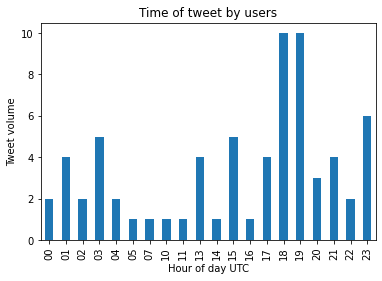

In [791]:
time_of_tweet(data_frame, keyword = 'biomanufacturing')

## How often do accounts tweet about...

In [769]:
path = f'/Users/maryward/twitter_project/data_Quick/images/'
def tweets_by_user(df2, keyword = None): #keyword
    '''returns a histogram of tweets by author_id
    to find key opinion leaders and basic twitter use by account'''
    df2["author_id"].value_counts().plot(kind = 'hist') #.sort_values(ascending = False)
    plt.title(f"Twitter Use per day by User, keyword: '{keyword}'")
    plt.xlabel('Number of tweets per day')
    plt.ylabel('Number of users')
    #if keyword is specified, image saved locally to image file
    if keyword:
        plt.savefig(f'{path}/{keyword}.user_tweet_freq_all.png')
    plt.show()
    #histogram of accounts that tweet more than 2x per day
    users_df = df2.groupby("author_id").agg("count")
    high_users = users_df[users_df['created_at']>2] #109/1399 users tweet more than 1 time per week
    high_users['created_at'].plot(kind = 'hist')
    plt.title(f"Twitter Use per day by User, keyword: '{keyword}'")
    plt.xlabel('Number of tweets per day')
    plt.ylabel('Number of users')
   # plt.close() 
    if keyword:
        plt.savefig(f'{path}/{keyword}.user_tweet_freq_high.png')
    plt.show()

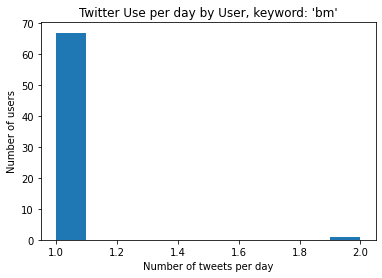

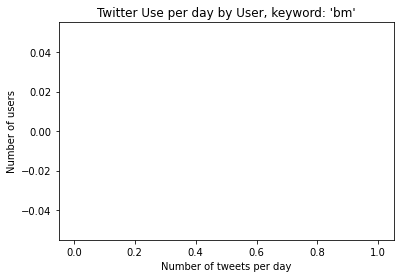

In [792]:
tweets_by_user(data_frame, keyword = 'bm')

## Topic analysis

### Clean tweet data

In [771]:
def clean_text_data(df):
    '''removes urls, mentions, and hashtags and lowercases the text
    returns DataFrame with clean_text, mentions, and hashtags as new columns'''
    df2 = df.copy()
    df2['clean_text'] = df2['text'].apply(lambda x: re.sub(r"https?://\S+", '', str(x), flags=re.MULTILINE))
    #store mentions
    mentions =df2['text'].apply(lambda x : re.findall("@([a-zA-Z0-9_]{1,50})", str(x)))
    df2['mentions'] = mentions
    #store hashtags
    hashtags = df2['text'].apply(lambda x : re.findall("#([a-zA-Z0-9_]{1,50})", str(x)))
    df2['hashtags'] = hashtags
    #remove mentions, remove hashtags
    df2['clean_text'] = df2['clean_text'].apply(lambda x: re.sub("@([a-zA-Z0-9_]{1,50})", '', str(x)))
    #df2['clean_text'] = df2['clean_text'].apply(lambda x: re.sub("#([a-zA-Z0-9_]{1,50})", '', str(x)))
    #lowercase
    df2['clean_text'] = df2['clean_text'].str.lower().str.strip()
    return df2

def label_retweets(df2):
    '''assigns 1 if "retweet"  and 0 if source tweet
    returns df2 with 'retweet' column'''
    retweet = []
    for  x in df2['clean_text']:
        if 'rt :' in x:
            retweet.append(1)
        else:
            retweet.append(0)
    #assign boolean to 'retweet'
    df2['retweet'] = retweet
    return df2

def clean_lemmatize(text):
    """cleans and lemmatizes the words with WordNetLemmatizer()"""
    for punctuation in string.punctuation:
        text = text.replace(punctuation, ' ') # Remove Punctuation
    lowercased = text.lower() # Lower Case
    tokenized = word_tokenize(lowercased) # Tokenize
    words_only = [word for word in tokenized if word.isalpha()] # Remove numbers
    stop_words = set(stopwords.words('english')) # Make stopword list
    without_stopwords = [word for word in words_only if not word in stop_words] # Remove Stop Words
    lemma=WordNetLemmatizer() # Initiate Lemmatizer
    lemmatized = [lemma.lemmatize(word) for word in without_stopwords] # Lemmatize
    return lemmatized

def apply_clean_lemmatize(df2):
    df2['clean_text_lemma'] = df2['clean_text'].apply(clean_lemmatize)
    df2['clean_text_lemma'] = df2['clean_text_lemma'].astype('str')
    return df2

In [793]:
clean_df = clean_text_data(data_frame)
clean_df = label_retweets(clean_df)
clean_df = apply_clean_lemmatize(clean_df)

### Topic Analysis

In [786]:
def LDA_trainer(df2, n_components = 4):
    '''Train a LDA model on text data, source, to extract potential topics
    currently 3 topic node used in the model'''
    source_tweet = df2[df2['retweet']==0]
    #initialize vectorizer
    vectorizer = CountVectorizer()
    data_vectorized = vectorizer.fit_transform(source_tweet['clean_text_lemma'])
    #initialize LDA model
    lda_model = LatentDirichletAllocation(n_components)
    lda_vectors = lda_model.fit_transform(data_vectorized)
    #get topics and put into a dict
    topic_dict = {}
    for idx, topic in enumerate(lda_model.components_):
        topic_dict["Topic %d:" % (idx)] = [(vectorizer.get_feature_names_out()[i], topic[i])for i in topic.argsort()[:-10 - 1:-1]]
    return topic_dict, vectorizer, lda_model

def get_topic(df2, vectorizer, lda_model):
    """takes a clean_text tweet and determines the topic it
    most likely belongs to. Good for tracking re-tweets and predicting trends
    based on word"""
    df = df2.copy()
    topic_LDA = []
    for i in range(len(df)):
        example = [df['clean_text'].iloc[i]]
        #Vectorize the example
        example_vectorized = vectorizer.transform(example)
        #use trained LDA model to predict topic
        lda_vectors = lda_model.transform(example_vectorized)
        ldas = {lda_vectors[0][0]:1,lda_vectors[0][1]:2, lda_vectors[0][2]:3}
        top = ldas[np.max([lda_vectors[0][0],lda_vectors[0][1],lda_vectors[0][2]])]
        topic_LDA.append(top)
    df['topic_LDA'] = topic_LDA
    return df

In [794]:
topic_dict, vectorizer, lda_model = LDA_trainer(clean_df)

In [795]:
topic_dict

{'Topic 0:': [('oil', 6.250478355179108),
  ('algal', 5.251253792859915),
  ('dha', 2.2500597927415606),
  ('sourced', 2.2499417561296378),
  ('omega', 2.2498808520803406),
  ('aquafeed', 2.2498218480115617),
  ('study', 2.2491704730882387),
  ('yet', 1.2499351844588111),
  ('increasingly', 1.2499351844588111),
  ('plant', 1.2499351844588111)],
 'Topic 1:': [('oil', 0.2501297918299303),
  ('vegan', 0.250126808710588),
  ('algal', 0.250121658369847),
  ('deep', 0.25010431019568796),
  ('dive', 0.25010431019568796),
  ('lca', 0.25010431019568796),
  ('sustainability', 0.25010431019568796),
  ('ingredient', 0.25010431019568796),
  ('effect', 0.250101212184022),
  ('study', 0.2501004478110606)],
 'Topic 2:': [('amp', 3.2499572561324417),
  ('ocean', 2.252815551906676),
  ('algal', 2.249489821503036),
  ('oil', 2.248173337937165),
  ('bloom', 1.2509781081598657),
  ('harmful', 1.2509781081598657),
  ('spill', 1.2509781081598657),
  ('effect', 1.2507088106300415),
  ('study', 1.2506798293694

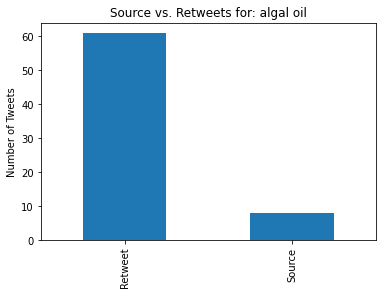

In [796]:
#ratio of retweets to tweets
clean_df['retweet'].value_counts().plot(kind='bar')
plt.title(f'Source vs. Retweets for: {keyword}')
plt.xticks([0,1], labels = {'Retweet':1,'Source':0})
plt.ylabel('Number of Tweets');

## Popular hashtags about...

In [425]:
def distribution_hashtags(df2): #keyword
    hashtags = {}
    for i,row in enumerate(df2['hashtags']):
        for x in df2['hashtags'].iloc[i]:
            if x in hashtags:
                hashtags[x] +=1
            else:
                hashtags[x] =1
    hashes = pd.DataFrame(hashtags.values(), hashtags.keys()).sort_values(0, ascending = False).reset_index().rename(columns = {'index':'hashtags', 0:'count'})
   # hashes.to_csv(f'{path}{keyword}.hashtags.csv')
    return hashes

In [798]:
hashes = distribution_hashtags(clean_df)
hashes[hashes['count']>1]

,hashtags,count


## Popular mentions on topic about...

In [427]:
def distribution_mentions(df2): #keyword
    mentions = {}
    for i,row in enumerate(df2['mentions']):
        for x in df2['mentions'].iloc[i]:
            if x in mentions:
                mentions[x] +=1
            else:
                mentions[x] =1
    mentions = pd.DataFrame(mentions.values(), mentions.keys()).sort_values(0, ascending = False).reset_index().rename(columns = {'index':'mentions', 0:'count'})
   # hashes.to_csv(f'{path}{keyword}.hashtags.csv')
    return mentions

In [778]:
mentions = distribution_mentions(clean_df)
mentions[mentions['count']>2]

,mentions,count
0,sbjennykan,21
1,raji143,17
2,BurleyResearch,15
3,adejimiadeniji,14
4,FirstCreateMe,13
...,...,...
63,denyyourtruth,3
64,Durgesh36301569,3
65,eureKAREfr,3
66,Nature,3


## Summary of tweets

### prepare tweets for summarizing

In [219]:
def tweets_to_string(df2):
    '''takes a DataFrame with clean_text and concatenates
    all the clean_text tweets into a single string for
    the summarization pipeline with summy'''
    df_users = df2.groupby('author_id').agg('count').sort_values('created_at', ascending=False)
    #filters tweets for accounts that tweeted at least 2x in time interval
    df_masses = df_users[df_users['created_at']>=2].reset_index()
    #df_masses = df2[df2['retweet']==0]
    
    full_text_punct = ""
    for i in range(len(df_masses)):
        df = df2[df2['author_id']==df_masses['author_id'][i]]
        df = df['clean_text'].apply(lambda x: re.sub('rt : ', ' ', x, flags=re.MULTILINE))
        df = df.reset_index()
        #separates each tweet by a period punctuation
        for j in range(len(df)):
            full_text_punct = full_text_punct + df['clean_text'].iloc[j] + '. '
    return full_text_punct

### Lex Rank Summarizer
summarizes based on frequency of sentence in document and returns number of sentences specified.

In [433]:
def Lex_Rank_summarizer(df2, sentences = 2):
    '''used for titling final product. summarizes based on frequency of sentence in document
    and returns number of sentences specified. Parser is instatiated.'''
    chunks = []
    count = 0
    
    for i in range(25,len(df2[df2['retweet']==0]), 25):
        document = ''

        for x in df2[df2['retweet']==0]['clean_text'].iloc[count:i].to_list():#
            document = document + x +'. '
        chunks.append(document)
        count += 25
    summaries = []
    for i in range(len(chunks)):
        parser = PlaintextParser.from_string(chunks[i], Tokenizer("english"))
        summarizer = LexRankSummarizer(Stemmer("english"))
        summary = summarizer(parser.document, 1)
        short_summary = [sentence for sentence in summary]
        summaries.append(short_summary)
    return summaries


In [750]:
lex_rank_sum = Lex_Rank_summarizer(clean_df, sentences = 1)
summaries = lex_rank_sum 
lex_rank_sum

[[<Sentence: learn more on the pathway website.. thanks to ,  and the ucl team for hosting today’s  science board meeting.>],
 [<Sentence: although canada has been slow at commercializing regenerative medicines, we are now investing and developing our biomanufacturing capacity.. briacell partners with waisman biomanufacturing to supply prostate cance...  via. . is hosting a biomanufacturing journal club featuring rodrigo ledesma-amaro on july 19th at 8am pt.>],
 [<Sentence: biotech and biomanufacturing here.>]]

Query 'bio manufacturing'. Lex Rank result <br>
'[[<Sentence: following a recent cabinet decision to approve the establishment of the africa biomanufacturing institute in #rwanda, the government is engaging a host of higher learning institutions to help train, re-skill and upskill professionals in the  industry.. the biomanufacturing revolution is one of the most promising solutions to our biggest global problems, from plastic pollution to preventing pandemics.>],<br>
 [<Sentence: contact  to learn more about phase 1 of our 1m rsf biomanufacturing campus, which is scheduled for delivery in 2023.. the #quad has begun to focus on other #emergingtech such as advanced #biotech, including synthetic biology, #genome sequencing, and #biomanufacturing, while exploring areas of cooperation among the quad countries.<br>
 [<Sentence: learn more about our upcoming mrna vaccine and #biomanufacturing facility.. gmp downstream biomanufacturing operator (2nd shift) - fargo - danaher #fargo #jobs.>],
 [<Sentence: #biomanufacturing.>],<br>
 [<Sentence: learn more on the pathway website.. thanks to ,  and the ucl team for hosting today’s  science board meeting.>]]'

In [139]:
len(clean_df[clean_df['retweet']==0])

137

### Luhn Summarizer
It selects only the words of higher importance as per their frequency in the corpus. Higher weights are assigned to the words present at the beginning of the document.

In [454]:
def Luhn_summarizer(full_text_punct, sentences = 4):
    '''Luhn’s algorithm is an approach based on TF-IDF.
    It selects only the words of higher importance as per their frequency.
    Higher weights are assigned to the words present at the begining of the document.
    Parser is instatiated.'''
    parser = PlaintextParser.from_string(full_text_punct, Tokenizer("english"))
    summarizer_luhn = LuhnSummarizer(Stemmer("english"))
    #summarizer_luhn.stop_words = get_stop_words("english")

    #Summarize the document with 2 sentences
    summary = summarizer_luhn(parser.document,sentences)
    summary1 = [sentence for sentence in summary]
    return summary

In [751]:
text = tweets_to_string(clean_df)
luhn_sum = Luhn_summarizer(text, sentences = 4)
summary1 = luhn_sum 
luhn_sum

(<Sentence: writes.. the #quad has begun to focus on other #emergingtech such as advanced #biotech, including synthetic biology, #genome sequencing, and #biomanufacturing, while exploring areas of cooperation among the quad countries.>,
 <Sentence: writes.. the #quad has begun to focus on other #emergingtech such as advanced #biotech, including synthetic biology, #genome sequencing, and #biomanufacturing, while exploring areas of cooperation among the quad countries.>,
 <Sentence: writes.. the #quad has begun to focus on other #emergingtech such as advanced #biotech, including synthetic biology, #genome sequencing, and #biomanufacturing, while exploring areas of cooperation among the quad countries.>,
 <Sentence: writes.. the #quad has begun to focus on other #emergingtech such as advanced #biotech, including synthetic biology, #genome sequencing, and #biomanufacturing, while exploring areas of cooperation among the quad countries.>)

__Query 'biomanufacturing':__<br>
<Sentence: writes.. the #quad has begun to focus on other #emergingtech such as advanced #biotech, including synthetic biology, #genome sequencing, and #biomanufacturing, while exploring areas of cooperation among the quad countries.>,<br>
 <Sentence: al) companies to rescue as well as #investment opportunities in #bone growth, #cartillage regeneration, #mitochondria medicine startups, organ #biofabrication #biomanufacturing , organoids, and #eye and #follicle regenerative med.. i'm actively looking for #neuro growth als parkinson’s companies to rescue as well as #investment opportunities in #bone growth, #cartillage regeneration, #mitochondria medicine startups, organ #biofabrication #biomanufacturing , organoids, and #eye and #follicle regenerative med.>)

### LSA Summarizer
Based on term frequency techniques with singular value decomposition to summarize texts.

In [193]:
def LSA_summarizer(full_text_punct, sentences = 2):
    '''Based on term frequency techniques with singular value decomposition to summarize texts.'''
    parser = PlaintextParser.from_string(full_text_punct, Tokenizer("english"))
    summarizer_lsa = LsaSummarizer(Stemmer("english"))
    summarizer_lsa.stop_words = get_stop_words("english")
    summary =summarizer_lsa(parser.document,sentences)
    summary3 = [sentence for sentence in summary]
    return summary3

In [752]:
lsa_sum = LSA_summarizer(text, sentences=4)
summary2 = lsa_sum 
lsa_sum

[<Sentence: the #quad has begun to focus on other #emergingtech such as advanced #biotech, including synthetic biology, #genome sequenci….>,
 <Sentence: the #quad has begun to focus on other #emergingtech such as advanced #biotech, including synthetic biology, #genome sequenci….>,
 <Sentence: we are thrilled to have kathleen munster, svp, enabling functions (quality, facilities, &amp; it) at  lead an engaging case study at #bmws22.>,
 <Sentence: gr8 chat about how #canada must be ambitious, #biomanufacturing, the power of smart investment &amp; the criticality of talent to drive it all.>]

### Text Rank Summarizer
Text rank is a graph-based summarization technique with keyword extractions in from document.

In [459]:
def text_rank_summarizer(full_text_punct, sentences = 4):
    '''Text rank is a graph-based summarization technique with keyword extractions in from document.'''
    parser = PlaintextParser.from_string(full_text_punct, Tokenizer("english"))
    summarizer = TextRankSummarizer(Stemmer("english"))
    summarizer.stop_words = get_stop_words("english")
    summary4 =summarizer(parser.document,sentences)
    return summary4

In [753]:
text_rank_sum = text_rank_summarizer(text)
summary3 = text_rank_sum
text_rank_sum

(<Sentence: writes.. the #quad has begun to focus on other #emergingtech such as advanced #biotech, including synthetic biology, #genome sequencing, and #biomanufacturing, while exploring areas of cooperation among the quad countries.>,
 <Sentence: writes.. the #quad has begun to focus on other #emergingtech such as advanced #biotech, including synthetic biology, #genome sequencing, and #biomanufacturing, while exploring areas of cooperation among the quad countries.>,
 <Sentence: writes.. the #quad has begun to focus on other #emergingtech such as advanced #biotech, including synthetic biology, #genome sequencing, and #biomanufacturing, while exploring areas of cooperation among the quad countries.>,
 <Sentence: writes.. the #quad has begun to focus on other #emergingtech such as advanced #biotech, including synthetic biology, #genome sequencing, and #biomanufacturing, while exploring areas of cooperation among the quad countries.>)

__Query 'bioanufacturing'__ <br>
<Sentence: writes.. the #quad has begun to focus on other #emergingtech such as advanced #biotech, including synthetic biology, #genome sequencing, and #biomanufacturing, while exploring areas of cooperation among the quad countries.>,<br>
 <Sentence: writes.. the #quad has begun to focus on other #emergingtech such as advanced #biotech, including synthetic biology, #genome sequencing, and #biomanufacturing, while exploring areas of cooperation among the quad countries.>

In [461]:
#create a dictionary of the summaries and save them to csv
def full_summary(summaries, summary1, summary2, summary3):
    sum_dict = {'lex_rank': summaries, 'luhn': summary1, 'lsa': summary2, 'text_rank':summary3}
    return sum_dict

In [462]:
sum_dict = full_summary(summaries, summary1, summary2, summary3)
summary_df = pd.DataFrame(sum_dict.values(), sum_dict.keys())
summary_df

,0,1,2,3,4,5,6,7,8,9,10,11,12
lex_rank,[let’s be honest: apple uses privacy as a form...,[#privacy #marketing.],[data privacy is the future of digital marketi...,[911 was an excuse for the gov to ramp up the ...,[#privacy #marketing.],[#privacy #marketing.],[#marketing #privacy.],[#privacy #marketing.],[wow in this era of women fighting to preserv...,[#privacy #marketing.],[18 - marketing in the era of data privacy],[why put that photo on instagram?don't you kno...,[improved security and privacy (no more unnece...
luhn,releases q1 2022 app store safety report; find...,"here’s why.. ""the federal trade commission wi...","she shares her wisdom on all things privacy, m...","she shares her wisdom on all things privacy, m...",None,None,None,None,None,None,None,None,None
lsa,the following website will allow you to opt-ou...,hong kong and singapore #privacy watchdogs hav...,#imarketz #marketingagency #digitalmarketing #...,tim glomb breaks down key takeaways from the r...,None,None,None,None,None,None,None,None,None
text_rank,mexico: personal data privacy in digital platf...,mexico: personal data privacy in digital platf...,let’s be honest: apple uses privacy as a form ...,📍though data privacy 🔐is fundamentally changin...,None,None,None,None,None,None,None,None,None


In [473]:
#save dataframe as {keyword}.summary.csv
path = f'/Users/maryward/twitter_project/data_Quick/'
keyword = 'privacy marketing'
def save_summaries_csv(df, keyword, path):
    path = path
    df.to_csv(f'{path}{keyword}.summary.csv')

In [474]:
save_summaries_csv(summary_df, keyword, path)

## Top tweeters about...

In [382]:
def top_tweeter(df2,retweet=None, fewer = 0):
    """takes a cleaned_df (labeled retweets, etc, returns data_frame 
    of the account with the most tweets over the last week """
    '''fewer term refers to the number of tweets posted less than the top tweeter'''
    if retweet==0:
        df2 = df2[df2['retweet']==0]
    #groups df2 by author_id and uses 'created_at' column to uniquely count the tweets
    df_users = df2.groupby('author_id').agg('count').sort_values('created_at', ascending=False)
    #highest tweet frequency
    top_tweets = np.max(df_users['created_at']) - fewer
    ##filters df_users for rows with highest tweets, here only one
    df_user = df_users[df_users['created_at']<=top_tweets].reset_index().iloc[0,0] 
    #get user tweet history with filtered 'author_id'
    df_user_df = df2[df2['author_id']== df_user]
    
    return df_user_df

In [755]:
top_tweeter_df = top_tweeter(clean_df, retweet = 0, fewer = 4)
top_tweeter_df.head()

,source,author_id,reply_settings,id,public_metrics,lang,context_annotations,text,created_at,conversation_id,referenced_tweets,in_reply_to_user_id,time,clean_text,mentions,hashtags,retweet,clean_text_lemma
52,Twitter Web App,26261464,everyone,1549044502936973313,"{'retweet_count': 2, 'reply_count': 2, 'like_c...",en,"[{'domain': {'id': '65', 'name': 'Interests an...",#RhodeIsland is home to many amazing businesse...,2022-07-18 14:52:44+00:00,1549044502936973313,NaN,NaN,14,#rhodeisland is home to many amazing businesse...,[],"[RhodeIsland, fintech, biomanufacturing, Ocean...",0,"['rhodeisland', 'home', 'many', 'amazing', 'bu..."


In [756]:
top_tweeter_df['text'].to_list()

['#RhodeIsland is home to many amazing businesses, from #fintech to #biomanufacturing and everything in between – we want to know which ones you admire! Tag your favorite company in the comments and let us know how they’ve made a splash in the #OceanState 🌊 ⬇️ https://t.co/3RKKOeySex']

In [476]:
#save dataframe as {keyword}.summary.csv
path = f'/Users/maryward/twitter_project/data_Quick/'
keyword = 'privacy marketing'
def save_top_tweeter_csv(df, keyword, path):
    path = path
    df.to_csv(f'{path}{keyword}.top_tweeter.csv')

In [477]:
save_top_tweeter_csv(top_tweeter_df, keyword, path)

## Most Frequent tweet about...

In [799]:
def retweet_freq(df2, num_tweets =2):
    '''takes cleaned and labeled df2 and returns dataframe of the 
    most frequently retweeted tweets'''
    retweet = df2[df2['retweet']==1]
    top_retweets = df2[df2['retweet']==1]['text'].value_counts().reset_index()
    count = 0
    lst = top_retweets['index'][:num_tweets].to_list()
    
    for i in range(len(retweet)):
        if retweet['text'].iloc[i] in lst:
            if count == 0:
                s1 = retweet.iloc[i]
                df = pd.DataFrame(s1).T
                count +=1
            else:
                s1 = pd.DataFrame(retweet.iloc[i]).T
                df = pd.concat([df,s1])
    df['twitter_handle'] = df['text'].apply(lambda x : re.findall("@([a-zA-Z0-9_]{1,50}):", str(x)))            
    return df  
                   

In [800]:
top_retweets_funct = retweet_freq(clean_df,num_tweets =10)
top_retweets_funct.head()

,text,public_metrics,in_reply_to_user_id,reply_settings,created_at,id,source,referenced_tweets,context_annotations,author_id,lang,conversation_id,time,clean_text,mentions,hashtags,retweet,clean_text_lemma,twitter_handle
0,RT @NASAOcean: We shore are excited! @NASA has...,"{'retweet_count': 61, 'reply_count': 0, 'like_...",NaN,everyone,2022-07-19 07:05:01+00:00,1549289189744984064,Twitter Web App,"[{'type': 'retweeted', 'id': '1549097582978183...","[{'domain': {'id': '46', 'name': 'Brand Catego...",1134329838368460800,en,1549289189744984064,07,rt : we shore are excited! has a new ocean co...,"[NASAOcean, NASA]",[],1,"['rt', 'shore', 'excited', 'new', 'ocean', 'co...",[NASAOcean]
1,RT @NASAOcean: We shore are excited! @NASA has...,"{'retweet_count': 61, 'reply_count': 0, 'like_...",NaN,everyone,2022-07-19 04:49:16+00:00,1549255025918083073,Twitter for iPhone,"[{'type': 'retweeted', 'id': '1549097582978183...","[{'domain': {'id': '46', 'name': 'Brand Catego...",1548310374096637958,en,1549255025918083073,04,rt : we shore are excited! has a new ocean co...,"[NASAOcean, NASA]",[],1,"['rt', 'shore', 'excited', 'new', 'ocean', 'co...",[NASAOcean]
2,RT @NASAOcean: We shore are excited! @NASA has...,"{'retweet_count': 61, 'reply_count': 0, 'like_...",NaN,everyone,2022-07-19 04:37:16+00:00,1549252005608443904,Twitter Web App,"[{'type': 'retweeted', 'id': '1549097582978183...","[{'domain': {'id': '46', 'name': 'Brand Catego...",1098981126725615617,en,1549252005608443904,04,rt : we shore are excited! has a new ocean co...,"[NASAOcean, NASA]",[],1,"['rt', 'shore', 'excited', 'new', 'ocean', 'co...",[NASAOcean]
3,RT @NASAOcean: We shore are excited! @NASA has...,"{'retweet_count': 61, 'reply_count': 0, 'like_...",NaN,everyone,2022-07-19 03:54:56+00:00,1549241352155643905,Twitter Web App,"[{'type': 'retweeted', 'id': '1549097582978183...","[{'domain': {'id': '46', 'name': 'Brand Catego...",1188464523713204224,en,1549241352155643905,03,rt : we shore are excited! has a new ocean co...,"[NASAOcean, NASA]",[],1,"['rt', 'shore', 'excited', 'new', 'ocean', 'co...",[NASAOcean]
4,RT @NASAOcean: We shore are excited! @NASA has...,"{'retweet_count': 61, 'reply_count': 0, 'like_...",NaN,everyone,2022-07-19 03:35:01+00:00,1549236338762858497,Twitter Web App,"[{'type': 'retweeted', 'id': '1549097582978183...","[{'domain': {'id': '46', 'name': 'Brand Catego...",1104914473,en,1549236338762858497,03,rt : we shore are excited! has a new ocean co...,"[NASAOcean, NASA]",[],1,"['rt', 'shore', 'excited', 'new', 'ocean', 'co...",[NASAOcean]


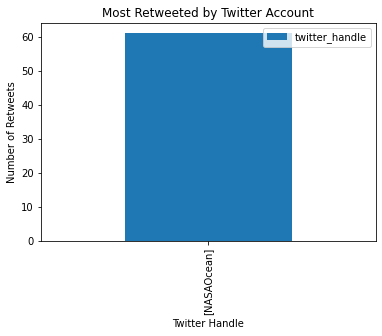

In [801]:
#most retweeted by twitter handle
pd.DataFrame(top_retweets_funct['twitter_handle'].value_counts()).plot(kind='bar')
plt.title('Most Retweeted by Twitter Account')
plt.xlabel('Twitter Handle')
plt.ylabel('Number of Retweets')
path = f'/Users/maryward/twitter_project/data_Quick/images/'
plt.savefig(f'{path}{keyword}.top_tweeter_handles.png')

In [644]:
#save dataframe as {keyword}.summary.csv
path = f'/Users/maryward/twitter_project/data_Quick/'
keyword = 'privacy marketing'
def save_top_tweeter_csv(df, keyword, path):
    path = path
    df.to_csv(f'{path}{keyword}.top_tweeter.csv')
    
    

In [645]:
save_top_tweeter_csv(top_retweets_funct,keyword,path)